In [1]:
#Bibliotecas propias
%matplotlib inline
import os,os.path,math,scipy
import PIL

from datasets import ClassLabel

#Bibliotecas para LeNet
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time


import torchvision
from torch import nn
from d2l import torch as d2l

import tensorflow as tf


In [2]:
#Se setean las seeds
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
def same_amount_of_n_images(img_dir_list,N):
    for img_dir in img_dir_list:
        img_count = len([name for name in os.listdir(img_dir) if os.path.isfile(os.path.join(img_dir, name))])
        if(img_count < N):
            return False
    return True

In [4]:
normalize = torchvision.transforms.Normalize(
    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    normalize])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    normalize])

In [5]:
def save (list_total,list_index,N):
    aux = np.random.choice(list_index, N, replace=False)
    list_total = np.append(list_total,aux)
    return list_total

In [6]:
def get_index_values(train_images,N):
    N = N
    aux = np.ndarray([0])
    index_list = np.ndarray([0])
    aux_label = 0
    largo = len(train_images)
    for i in range(largo):
        label_y = train_images[i][1]
        if label_y == aux_label:
            aux = np.append(aux,i)
        else:
            aux_label = label_y
            i= i-1
            index_list = save(index_list,aux,N)
            aux = np.ndarray([0])
    index_list = save(index_list,aux,N)
    return index_list
        

In [131]:
#Se define la cantidad N de ejemplos por clase
N = 30

#Numero de iteraciones para aumentar la cantidad de imagenes.
n_iteraciones = 20

AcuraIntegraTypeR2001_dir = 'data/train/AcuraIntegraTypeR2001'
AcuraRLSedan2012_dir = 'data/train/AcuraRLSedan2012'
AcuraTLSedan2012_dir = 'data/train/AcuraTLSedan2012'
AcuraTLType_S2008_dir = 'data/train/AcuraTLType_S2008'
AcuraTSXSedan2012_dir = 'data/train/AcuraTSXSedan2012'
aux_dir_list = [AcuraIntegraTypeR2001_dir,AcuraRLSedan2012_dir,AcuraTLSedan2012_dir,AcuraTLType_S2008_dir,AcuraTSXSedan2012_dir]

if same_amount_of_n_images(aux_dir_list,N):
    train_images = []
    test_images = []
    for i in range(n_iteraciones):
        train_aux = torchvision.datasets.ImageFolder('data/train',train_augs)
        train_images = torch.utils.data.ConcatDataset([train_images,train_aux])
        test_aux = torchvision.datasets.ImageFolder('data/test',test_augs)
        test_images = torch.utils.data.ConcatDataset([test_images,test_aux])    
    #Se obtienen los indicies para las N imagenes de cada clase.
    train_index = get_index_values(train_images,N)
    train_images = torch.utils.data.Subset(train_images, train_index.astype(int))
    
    test_size = int(0.3 * len(train_images))
    
    test_data = torch.utils.data.Subset(test_images, np.random.choice(len(test_images), test_size, replace=False))
    
else:
    print('N invalido')

In [132]:
valid_size = int(0.1 * len(train_images))
train_size = len(train_images) - valid_size

# Se separa el dataset y se guarda uno de entrenamiento y otro de validación
train_data, valid_data = torch.utils.data.random_split(train_images, [train_size, valid_size])



In [133]:
#Se crean los dataloaders para procesar los datos a travez de las iteraciones.
#Se trabaja con un tamaño de lote BATCH_SIZE
BATCH_SIZE = 32

train_iterator = data.DataLoader(test_data,
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)
test_iterator = data.DataLoader(test_data, 
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(test_data, 
                                 batch_size = BATCH_SIZE)

In [134]:
class LeNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, 
                               out_channels = 6, 
                               kernel_size = 5)
        self.conv2 = nn.Conv2d(in_channels = 6, 
                               out_channels = 16, 
                               kernel_size = 5)
        self.fc_1 = nn.Linear(44944, 120)
        self.fc_2 = nn.Linear(120, 84)
        self.fc_3 = nn.Linear(84, output_dim)

    def forward(self, x):
        #Primera capa
        x = self.conv1(x)
        x = F.max_pool2d(x, kernel_size = 2)
        x = F.relu(x)
        
        #Segunda capa
        x = self.conv2(x)
        x = F.max_pool2d(x, kernel_size = 2)
        x = F.relu(x)
        
        x = x.view(x.shape[0], -1)
        h = x
        x = self.fc_1(x)
        
        x = F.relu(x)
        x = self.fc_2(x)
        
        x = F.relu(x)
        x = self.fc_3(x)

        return x, h

In [135]:
OUTPUT_DIM = 10
model = LeNet(OUTPUT_DIM)

In [136]:
optimizer = optim.Adam(model.parameters())

In [137]:
criterion = nn.CrossEntropyLoss()

In [138]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [139]:
model = model.to(device)
criterion = criterion.to(device)

In [140]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [141]:
def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = torch.tensor(y).to(device)
        #y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred, _ = model(x)
        
        loss = criterion(y_pred, y)
        
        acc = calculate_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [142]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = torch.tensor(y).to(device)
            #y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [143]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [144]:
EPOCHS = 3

best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    start_time = time.monotonic()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')
    
    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

/Users/matiascoronado/opt/anaconda3/envs/python3-7/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/Users/matiascoronado/opt/anaconda3/envs/python3-7/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Epoch: 01 | Epoch Time: 0m 40s
	Train Loss: 1.255 | Train Acc: 52.69%
	 Val. Loss: 0.531 |  Val. Acc: 82.76%
Epoch: 02 | Epoch Time: 0m 40s
	Train Loss: 0.183 | Train Acc: 95.58%
	 Val. Loss: 0.024 |  Val. Acc: 99.68%
Epoch: 03 | Epoch Time: 0m 39s
	Train Loss: 0.014 | Train Acc: 99.78%
	 Val. Loss: 0.033 |  Val. Acc: 98.81%


In [145]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [146]:
images, labels, probs = get_predictions(model, test_iterator, device)

In [147]:
pred_labels = torch.argmax(probs, 1)

In [148]:
def plot_confusion_matrix(labels, pred_labels):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = range(10));
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)

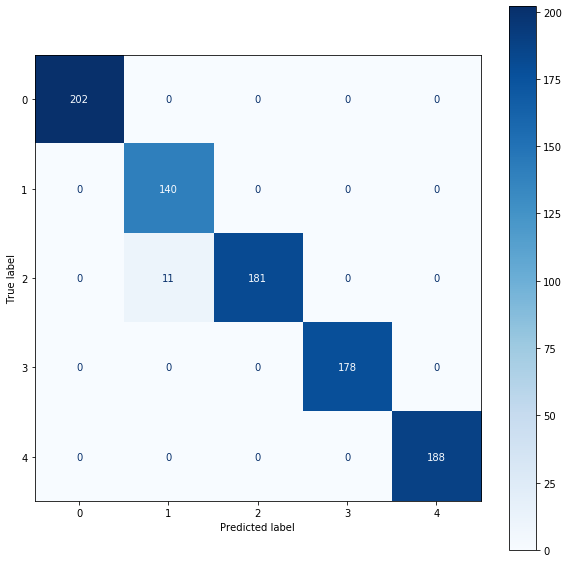

In [149]:
plot_confusion_matrix(labels, pred_labels)